In [1]:
#from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import os
import time
import datetime as dt
import xarray as xr
from datetime import datetime
import pandas
import matplotlib.pyplot as plt
import numpy as np
import math
import cartopy.crs as ccrs
dir_storm_wmo='F:/data/tc_wakes/ibtracks/year/'

####################you will need to change some paths here!#####################
#list of input directories
dir_storm_info='f:/data/tc_wakes/database/info/'
dir_out='f:/data/tc_wakes/database/sst/'
dir_flux = 'F:/data/model_data/oaflux/data_v3/daily/turbulence/'
dir_cmc = 'F:/data/sst/cmc/CMC0.2deg/v2/'
dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
##where to get the data through opendap, use these directories instead
#dir_cmc = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/CMC/CMC0.1deg/v3/'
#dir_flux = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/WHOI_OAFlux/version3/daily/lh_oaflux/'
#the latest ccmp is from www.remss.com but they do not have an opendap server so you can use this instead:
#dir_ccmp='https://podaac-opendap.jpl.nasa.gov/opendap/allData/ccmp/L3.0/flk/'

#################################################################################
import geopy.distance
from math import sin, pi
from scipy import interpolate

#functions for running storm data
import sys
sys.path.append('C:/Users/gentemann/Google Drive/d_drive/python/storm_heat_content/subroutines/')
from storm_masking_routines import interpolate_storm_path
from storm_masking_routines import get_dist_grid
from storm_masking_routines import closest_dist
from storm_masking_routines import calculate_storm_mask


In [ ]:
input_year=int(str(sys.argv[1]))
print ('processing year:', input_year)


In [3]:
input_year = 2010
input_storm = 20
date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
isave_mld_year = 0 #init MLD monthly data read flag
for root, dirs, files in os.walk(dir_storm_info, topdown=False):
    if root[len(dir_storm_info):len(dir_storm_info)+1]=='.':
        continue
    for name in files:
        if not name.endswith('.nc'):
            continue
        filename=os.path.join(root, name)
        print(filename[36:39],filename[31:35])
        inum_storm=int(filename[36:39])
        iyr_storm=int(filename[31:35])

        if iyr_storm!=input_year:
            continue
        if input_storm!=inum_storm:
            continue

#        if iyr_storm!=2007: # or iyr_storm<2003:
#            continue
        print(name,filename)
        ds_storm_info = xr.open_dataset(filename)
        lats = ds_storm_info.lat[0,:]
        lons = ds_storm_info.lon[0,:]  #lons goes from 0 to 360
        lons = (lons + 180) % 360 - 180 #put -180 to 180
        dysince = ds_storm_info.time
        ds_storm_info.close()
#        print(ds_storm_info)
#        break
#        ds_storm_interp = interpolate_storm_path(ds_storm_info)
#        print(ds_storm_interp)
#        break

#make lat and lon of storm onto 25 km grid for below
        lons = (((lons - .125)/.25+1).astype(int)-1)*.25+.125
        lats = (((lats + 89.875)/.25+1).astype(int)-1)*.25-89.875
        
        iwrap=0
#calculate size of box to get data in
        minlon,maxlon = min(lons.values)-10, max(lons.values)+10
        minlat,maxlat = min(lats.values)-10, max(lats.values)+10

        ydim_storm = round((maxlat - minlat)/.25).astype(int)
        new_lat_storm = np.linspace(minlat, maxlat, ydim_storm)
        if (minlon<-90 and maxlon>=90) or (minlon<-180 and maxlon<0):  #this storm wraps  keep everythig 0 to 360 then wrap data at very end
            iwrap = 1
            lons2 = np.mod(lons, 360)
            minlon, maxlon = min(lons2.values)-10, max(lons2.values)+10
            xdim_storm = round((maxlon - minlon)/.25).astype(int)
            new_lon_storm = np.linspace(minlon, maxlon, xdim_storm)
        else:
            xdim_storm = round((maxlon - minlon)/.25).astype(int)
            new_lon_storm = np.linspace(minlon, maxlon, xdim_storm)

        print(iwrap,minlon,maxlon)
        print(iwrap,xdim_storm, new_lon_storm[:5],new_lon_storm[-5:])

        
        dims=lats.shape
        tdim=dims[0]
        tem_date=[0]*tdim #print(dysince.values)
        for i in range(0,tdim):
            tem_date[i]=date_1858+dt.timedelta(days=float(dysince[0,i].values))  #create new time array that can be queried for year etc
        min_date = min(tem_date)+dt.timedelta(days=-5)
#        max_date = max(tem_date)+dt.timedelta(days=5)
        minjdy = min_date.timetuple().tm_yday  #create new time array that can be queried for year etc
        minyear =min_date.year #create new time array that can be queried for year etc
        minmon =min_date.month #create new time array that can be queried for year etc
        minday =min_date.day #create new time array that can be queried for year etc
#        maxjdy = max_date.timetuple().tm_yday  #create new time array that can be queried for year etc
#        maxyear =max_date.year  #create new time array that can be queried for year etc
        print(minyear,minjdy)#,maxyear,maxjdy)
        
        dif = max(tem_date)-min(tem_date)
        tdim=int(dif.days)+45             #calculate ssts for 30 days after storm
        
        #print(tdim,xdim,ydim)            
        
        #print('sst_out_sv',sst_out_sv.shape)
        for i in range(0,tdim):
            storm_date = dt.datetime(minyear,minmon,minday)+dt.timedelta(days=i)+dt.timedelta(hours=12)
            #print(storm_date)
            
            syr=str(storm_date.year)
            smon=str(storm_date.month)
            sdym=str(storm_date.day)
            sjdy=str(storm_date.timetuple().tm_yday)

#sst data   
            fname_tem=syr + smon.zfill(2) + sdym.zfill(2) + '120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
            filename = dir_cmc + syr + '/' + sjdy.zfill(3) + '/' + fname_tem
            ds_day=xr.open_dataset(filename,drop_variables=['analysis_error','sea_ice_fraction'])
            if iwrap==1:  #data is -180 to 180 for sst, so need to bring to 0 to 360 when wrapped
                ds_day.coords['lon'] = np.mod(ds_day['lon'], 360)
                ds_day = ds_day.sortby(ds_day.lon)
            ds_day.close()
            ds_day = ds_day.where(ds_day['mask'] == 1.) 
            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
            #ds_storm['time']=storm_date
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            if i==0:
                ds_storm_sst = ds_storm
            else:
                ds_storm_sst = xr.concat([ds_storm_sst,ds_storm],dim='time')

#sst climatology  
            if storm_date.timetuple().tm_yday==366:
                sjdy = '365'
            filename='F:/data/sst/cmc/CMC0.2deg/v2/climatology/clim1993_2016' + sjdy.zfill(3) + '-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
            ds_day=xr.open_dataset(filename,drop_variables=['analysis_error','sea_ice_fraction','sq_sst'])
            ds_day = ds_day.rename({'analysed_sst':'analysed_sst_clim','mask':'mask_clim'}) #, inplace = True)            
            if iwrap==1:  #data is -180 to 180 for sst, so need to bring to 0 to 360 when wrapped
                ds_day.coords['lon'] = np.mod(ds_day['lon'], 360)
                ds_day = ds_day.sortby(ds_day.lon)
            ds_day.close()
            ds_day = ds_day.where(ds_day['mask_clim'] == 1.) 
            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
            ds_storm = ds_storm.assign_coords(time=storm_date)
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            if i==0:
                ds_storm_sst_clim = ds_storm
            else:
                ds_storm_sst_clim = xr.concat([ds_storm_sst_clim,ds_storm],dim='time')           
            
#ccmp wind data, no masked data, a complete field
#            lyr, idyjl = 2015,1
#            storm_date = dt.datetime(2015,1,1)
            syr, smon, sdym, sjdy=str(storm_date.year),str(storm_date.month),str(storm_date.day),str(storm_date.timetuple().tm_yday)
            fname_tem='/CCMP_Wind_Analysis_' + syr + smon.zfill(2) + sdym.zfill(2) + '_V02.0_L3.0_RSS.nc'
            ccmp_filename = dir_ccmp + syr + '/M' + smon.zfill(2) + fname_tem      
            ds=xr.open_dataset(ccmp_filename,drop_variables=['nobs'])
            ds_day = ds.mean(dim='time')     #take average across all 6 hourly data fields
            ds_day = ds_day.rename({'longitude':'lon','latitude':'lat'}) #, inplace = True)            
            if iwrap==0:
                ds_day.coords['lon'] = (ds_day.coords['lon'] + 180) % 360 - 180
                ds_day = ds_day.sortby(ds_day.lon)
            ds.close()
            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            ds_storm = ds_storm.assign_coords(time=storm_date)
            if i==0:
                ds_storm_ccmp = ds_storm
            else:
                ds_storm_ccmp = xr.concat([ds_storm_ccmp,ds_storm],dim='time')
              
#ocean mixed layer depth from monthly data GODAS NOAA, lon 0 to 360, monthly data so interp to day
#this is monthly data (all other data daily) so need to read in year before and year after
#so any storms <1/15 or greater than 12/15 in the year still get data
#dir_godas='https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/godas/'
            dir_godas = 'f:/data/model_data/godas/'
            if isave_mld_year != storm_date.year:
                filename = dir_godas + 'dbss_obml.' + str(storm_date.year-1) + '.nc'
                ds_day_mld=xr.open_dataset(filename)
                ds_day_mld['time']=ds_day_mld.time+np.timedelta64(14,'D')  #data provider gave 1st day of ave in time 
                ds_day_mld.close()
                filename = dir_godas + 'dbss_obml.' + str(storm_date.year) + '.nc'
                ds_day_mld2=xr.open_dataset(filename)
                ds_day_mld2['time']=ds_day_mld2.time+np.timedelta64(14,'D')  #data provider gave 1st day of ave in time 
                ds_day_mld2.close()
                ds_day_mld = xr.concat([ds_day_mld,ds_day_mld2],dim='time')
                filename = dir_godas + 'dbss_obml.' + str(storm_date.year+1) + '.nc'
                ds_day_mld2=xr.open_dataset(filename)
                ds_day_mld2['time']=ds_day_mld2.time+np.timedelta64(14,'D')  #data provider gave 1st day of ave in time 
                ds_day_mld2.close()
                ds_day_mld = xr.concat([ds_day_mld,ds_day_mld2],dim='time')
                if iwrap==0:
                    ds_day_mld.coords['lon'] = (ds_day_mld.coords['lon'] + 180) % 360 - 180
                    ds_day_mld = ds_day_mld.sortby(ds_day_mld.lon)
                isave_mld_year = storm_date.year
            ds_storm = ds_day_mld.interp(time = storm_date, lat = new_lat_storm,lon = new_lon_storm)
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            ds_storm = ds_storm.assign_coords(time=storm_date)
            if i==0:
                ds_storm_mld = ds_storm
            else:
                ds_storm_mld = xr.concat([ds_storm_mld,ds_storm],dim='time')            
            
#latent heat flux data, masked already set to NaN                
            filename = dir_flux + 'lh_oaflux_' + syr + '.nc';
            ds=xr.open_dataset(filename,drop_variables=['err'])
            ds_day = ds.sel(time = storm_date.timetuple().tm_yday)  #select day of year from annual file
            if iwrap==0:
                ds_day.coords['lon'] = (ds_day.coords['lon'] + 180) % 360 - 180
                ds_day = ds_day.sortby(ds_day.lon)
            ds.close()
            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            ds_storm['time']=storm_date
            if i==0:
                ds_storm_lhf = ds_storm
            else:
                ds_storm_lhf = xr.concat([ds_storm_lhf,ds_storm],dim='time')

#sensible heat flux data , masked already set to NaN                
            filename = dir_flux + 'sh_oaflux_' + syr + '.nc';
            ds=xr.open_dataset(filename,drop_variables=['err'])
            ds_day = ds.sel(time = storm_date.timetuple().tm_yday)  #select day of year from annual file
            if iwrap==0:
                ds_day.coords['lon'] = (ds_day.coords['lon'] + 180) % 360 - 180
                ds_day = ds_day.sortby(ds_day.lon)
            ds.close()
            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            ds_storm['time']=storm_date
            if i==0:
                ds_storm_shf = ds_storm
            else:
                ds_storm_shf = xr.concat([ds_storm_shf,ds_storm],dim='time')

#surface humid flux data   , masked already set to NaN              
            filename = dir_flux + 'qa_oaflux_' + syr + '.nc';
            ds=xr.open_dataset(filename,drop_variables=['err'])
            ds_day = ds.sel(time = storm_date.timetuple().tm_yday)  #select day of year from annual file
            if iwrap==0:
                ds_day.coords['lon'] = (ds_day.coords['lon'] + 180) % 360 - 180
                ds_day = ds_day.sortby(ds_day.lon)
            ds.close()
            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            ds_storm['time']=storm_date
            if i==0:
                ds_storm_qa = ds_storm
            else:
                ds_storm_qa = xr.concat([ds_storm_qa,ds_storm],dim='time')

#air temp flux data   , masked already set to NaN              
            filename = dir_flux + 'ta_oaflux_' + syr + '.nc';
            ds=xr.open_dataset(filename,drop_variables=['err'])
            ds_day = ds.sel(time = storm_date.timetuple().tm_yday)  #select day of year from annual file
            if iwrap==0:
                ds_day.coords['lon'] = (ds_day.coords['lon'] + 180) % 360 - 180
                ds_day = ds_day.sortby(ds_day.lon)
            ds.close()
            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            ds_storm['time']=storm_date
            if i==0:
                ds_storm_ta = ds_storm
            else:
                ds_storm_ta = xr.concat([ds_storm_ta,ds_storm],dim='time')
                
#        ds_all = xr.merge([ds_storm_ccmp, ds_storm_mld, ds_storm_lhf, ds_storm_shf, ds_storm_ta, ds_storm_qa, ds_storm_sst, ds_storm_sst_clim])
        ds_all = xr.merge([ds_storm_ccmp, ds_storm_mld, ds_storm_lhf, ds_storm_shf, ds_storm_ta, ds_storm_qa, ds_storm_sst,ds_storm_sst_clim])

        #calculate mask
#        print('caluculating mask')
#        ds_mask = calculate_storm_mask(ds_all,lats,lons)
#        ds_all['storm_mask']=ds_mask['storm_mask']
#        #dist to storm
#        print('calculating dist')
#        dist,index,stime,position = closest_dist(ds_all,ds_storm_info)
#        dtem=xr.DataArray(dist, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
#        ds_all['dist_from_storm_km']=dtem
#        dtem=xr.DataArray(index, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
#        ds_all['closest_storm_index']=dtem
#        dtem=xr.DataArray(stime, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
#        ds_all['closest_storm_time']=dtem
#        dtem=xr.DataArray(position, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
#        ds_all['side_of_storm']=dtem

        if iwrap==1:
            ds_all.coords['lon'] = np.mod(ds_all['lon'], 360)
            ds_storm_info['lon'] = np.mod(ds_storm_info['lon'], 360)

        #calculate mask
        print('caluculating mask')
        ds_mask = calculate_storm_mask(ds_all,lats,lons)
        ds_all['storm_mask']=ds_mask['storm_mask']
        #dist to storm
        print('calculating dist')
        dist,index,stime,position,ds_storm_interp = closest_dist(ds_all,ds_storm_info)
        dtem=xr.DataArray(dist, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
        ds_all['dist_from_storm_km']=dtem
        dtem=xr.DataArray(index, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
        ds_all['closest_storm_index']=dtem
        dtem=xr.DataArray(stime, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
        ds_all['closest_storm_time']=dtem
        dtem=xr.DataArray(position, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
        ds_all['side_of_storm']=dtem
       
        xdim,ydim,tdim = ds_all.lon.shape[0],ds_all.lat.shape[0],ds_all.time.shape[0]
        wtem=np.empty([ydim,xdim])
        ptem=np.empty([ydim,xdim])
        stem=np.empty([ydim,xdim])
        for i in range(0,xdim):
            for j in range(0,ydim):
                storm_index = ds_all.closest_storm_index[j,i].data
                wtem[j,i]=ds_storm_interp.wind[0,int(storm_index)].data
                ptem[j,i]=ds_storm_interp.pres[0,int(storm_index)].data
                stem[j,i]=ds_storm_interp.storm_speed_kmhr[0,int(storm_index)].data
        xrtem=xr.DataArray(wtem, coords={'lat': ds_all.lat.values, 'lon':ds_all.lon.values}, dims=('lat', 'lon'))        
        ds_all['wmo_storm_wind']=xrtem
        xrtem=xr.DataArray(ptem, coords={'lat': ds_all.lat.values, 'lon':ds_all.lon.values}, dims=('lat', 'lon'))        
        ds_all['wmo_storm_pres']=xrtem
        xrtem=xr.DataArray(stem, coords={'lat': ds_all.lat.values, 'lon':ds_all.lon.values}, dims=('lat', 'lon'))        
        ds_all['wmo_storm_speed_kmhr']=xrtem
        
        #find max sst 5 days before storm location
        #first create an array with the storm crossover time (from nearest point) as an array
        sdate = np.empty([ydim,xdim], dtype=dt.datetime)    
        for i in range(0,xdim):
            for j in range(0,ydim):
                tem=date_1858+dt.timedelta(days=float(ds_all.closest_storm_time[j,i])) 
                sdate[j,i]=np.datetime64(tem)
        xsdate=xr.DataArray(sdate, coords={'lat': ds_all.lat.values, 'lon':ds_all.lon.values}, dims=('lat', 'lon'))    
        ds_all['closest_storm_time_np64']=xsdate
        #now use array of storm time to calculate prestorm sst
        sst0 = ds_all.dist_from_storm_km.copy(deep=True)
        sst0_clim_anom = ds_all.dist_from_storm_km.copy(deep=True)
        for i in range(0,xdim):
            for j in range(0,ydim):
                #sst0[j,i] = ds_data.analysed_sst[:,j,i].interp(time=xsdate[j,i])
                sst0[j,i] = ds_all.analysed_sst[:,j,i].sel(time=slice(xsdate[j,i]-np.timedelta64(5,'D'),xsdate[j,i])).max()
                sst0_clim_anom[j,i] = (ds_all.analysed_sst[:,j,i]-ds_all.analysed_sst_clim[:,j,i]).sel(time=slice(xsdate[j,i]-np.timedelta64(5,'D'),xsdate[j,i])).max()
        ds_all['sst_prestorm']=sst0
        ds_all['sst_prestorm_clim']=sst0_clim_anom
#create sst anomalies
        ds_all['sst_anom']=ds_all.analysed_sst-ds_all.analysed_sst_clim
#now calculate coldwake information
        if abs(ds_all.lon[-1]-ds_all.lon[0])>180:
            ds_all.coords['lon'] = np.mod(ds_all['lon'], 360)
            ds_storm_interp['lon'] = np.mod(ds_storm_interp['lon'], 360)
        max_lat = ds_storm_interp.lat.max()

    #remove all data outsice 100km/800km or cold wake >0 or <-10
        if max_lat<0:
            cond = ((((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm<=0)) | 
            ((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm>0))) )       
        else:
            cond = ((((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm<0)) | 
            ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm>=0))))            
        subset = ds_all.where(cond)
          
        xdim,ydim,tdim = ds_all.lon.shape[0],ds_all.lat.shape[0],ds_all.time.shape[0]
        date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
        coldwake_max=ds_all.sst_prestorm.copy(deep=True)*np.nan
        coldwake_maxindex=ds_all.sst_prestorm.copy(deep=True)*np.nan
        coldwake_hrtomaxcold=ds_all.sst_prestorm.copy(deep=True)*np.nan
        coldwake_recovery=ds_all.sst_prestorm.copy(deep=True)*np.nan
#go through entire array lat/lon dims
        for i in range(0,xdim):
            for j in range(0,ydim):
                 #calculate the storm time for the closest collocated storm point then find the combined data index for closest time
                #this gives you the combined data storm index cross over
                storm_date64 = ds_all.closest_storm_time_np64[j,i]
                if np.isnan(subset.analysed_sst[0,j,i]):  #don't process masked values
                    continue
                time_diff = subset.time-storm_date64
                storm_index = np.argmin(abs(time_diff)).data
                #now look for cold wake for 1 day before strom to 5 days after strom
                #caluclate hours to cold wake, maximum cold wake, hours until it returns to prestorm sst
                #there is NO filter on wheither coldwake large enough here, just does all points
                istart,iend = int(storm_index),int(storm_index)+8
                if iend>tdim:
                    iend=tdim
                if np.isnan(subset.sst_prestorm_clim[j,i]):
                    continue
                #coldwake_max[j,i] = (subset.analysed_sst[istart:iend,j,i]-subset.sst_prestorm[j,i]).min()
                coldwake_max[j,i] = (subset.sst_anom[istart:iend,j,i]-subset.sst_prestorm_clim[j,i]).min()
                if all(np.isnan(subset.sst_anom[istart:iend,j,i])):
                    continue
                itmp = np.argmin(subset.sst_anom[istart:iend,j,i]-subset.sst_prestorm_clim[j,i]).data
                coldwake_maxindex[j,i]=istart+itmp
                delay = subset.time[istart+itmp].values-subset.time[istart].values
                coldwake_hrtomaxcold[j,i]=delay / np.timedelta64(1, 'h')
                for k in range(istart+itmp,tdim):
                    sst_change = subset.sst_anom[k,j,i]-subset.sst_prestorm_clim[j,i]
                   # sst_change_clim = subset.analysed_sst_clim[k,j,i]-subset.sst_prestorm_clim[j,i]
            #NEED TO ADD CLIMATOLOGY SST CHANGE HERE
                    if sst_change>-0.1:  #changed 2/27 based on dare and mcbride paper criteria
                        break
                delay = subset.time[k].values-subset.time[istart].values
                coldwake_recovery[j,i]=delay / np.timedelta64(1, 'D')

        ds_all['coldwake_max']=coldwake_max
        ds_all['coldwake_maxindex']=coldwake_maxindex
        ds_all['coldwake_hrtomaxcold']=coldwake_hrtomaxcold
        ds_all['coldwake_dytorecovery']=coldwake_recovery
        
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined_data.nc'
        ds_all.to_netcdf(filename)
        print('out:',filename)
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track.nc'
        ds_storm_interp.to_netcdf(filename)
        print('out:',filename)
    




001 2002
002 2002
005 2002
007 2002
009 2002
010 2002
011 2002
012 2002
013 2002
014 2002
015 2002
017 2002
018 2002
019 2002
020 2002
021 2002
022 2002
023 2002
025 2002
027 2002
028 2002
030 2002
031 2002
033 2002
034 2002
035 2002
036 2002
037 2002
039 2002
040 2002
041 2002
042 2002
043 2002
046 2002
047 2002
048 2002
049 2002
050 2002
051 2002
052 2002
053 2002
054 2002
055 2002
056 2002
058 2002
060 2002
061 2002
063 2002
064 2002
066 2002
067 2002
068 2002
069 2002
070 2002
072 2002
075 2002
077 2002
081 2002
082 2002
083 2002
084 2002
002 2003
003 2003
004 2003
005 2003
006 2003
008 2003
009 2003
010 2003
011 2003
012 2003
013 2003
015 2003
016 2003
017 2003
018 2003
019 2003
021 2003
022 2003
023 2003
024 2003
025 2003
026 2003
027 2003
028 2003
031 2003
032 2003
033 2003
034 2003
035 2003
036 2003
037 2003
038 2003
040 2003
042 2003
044 2003
046 2003
047 2003
048 2003
049 2003
050 2003
051 2003
055 2003
057 2003
059 2003
060 2003
064 2003
065 2003
066 2003
067 2003
070 2003
0

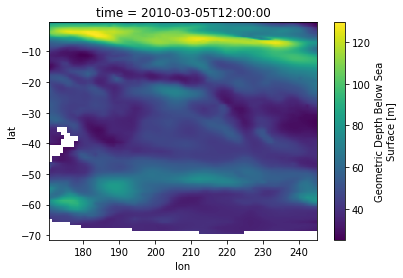

In [4]:
ds_all.dbss_obml[0,:,:].plot()

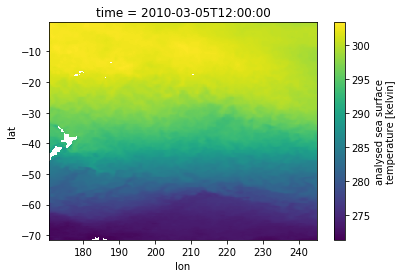

In [5]:
ds_all.analysed_sst[0,:,:].plot()


In [ ]:
iyr_storm=2010
inum_storm=20
filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined_data.nc'
ds_old = xr.open_dataset(filename)
ds_old.close()

In [ ]:
ds_old.dbss_obml[0,:,:].plot()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

for iyr_storm in range(2010,2017):
#inum_storm = 55
#for iyr_storm in range(2003,2011):
    filename=dir_storm_wmo+'Year.'+str(iyr_storm)+'.ibtracs_wmo.v03r10.nc'
    ds_ibtrak = xr.open_dataset(filename)
    ds_ibtrak.close()
    for inum_storm in range(0,100): #0,100):#100): #(0,100): #100):
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track.nc'
        exists = os.path.isfile(filename)
        if exists:       
            print(filename)
            ds_storm_info=xr.open_dataset(filename)
            ds_storm_info = ds_storm_info.sel(j2=0)
            ds_storm_info.close()
            filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined_data.nc'
            ds_all = xr.open_dataset(filename)
            ds_all['spd']=np.sqrt(ds_all.uwnd**2+ds_all.vwnd**2)
            ds_all.close()
            icenter=0

    #        if ds_all.lon.max()>180:
    #            ds_all.coords['lon'] = (ds_all.coords['lon'] + 180) % 360 - 180

            if ((abs(ds_storm_info.lon[-1]-ds_storm_info.lon[0])>180) | ((ds_all.lon[-1].data>180) & (ds_all.lon[0].data<180))):
    #            ds_all.coords['lon'] = np.mod(ds_all['lon'], 360)
    #            ds_storm_info['lon'] = np.mod(ds_storm_info['lon'], 360)
                icenter=-180
            max_lat = ds_storm_info.lat.max()
            #remove all data outsice 100km/800km or cold wake >0 or <-10
            if max_lat<0:
                cond = ((((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm<=0)) | 
                ((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm>0))) 
                & (ds_all.coldwake_max<=-.1) & (ds_all.coldwake_max>=-10))
            else:
                cond = ((((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm<0)) | 
                ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm>=0))) 
                & (ds_all.coldwake_max<=-.1) & (ds_all.coldwake_max>=-10))
            subset = ds_all.where(cond)

            #create coldwake anomaly with nan for all values before wmo storm time
            subset['sst_anomaly']=subset.analysed_sst-subset.sst_prestorm

            frac = ds_all.lon.size/ds_all.lat.size*1.2

            #create array with day.frac since closest storm passage
            tdif_dy = (subset.time-subset.closest_storm_time_np64)/np.timedelta64(1, 'D')
            subset['tdif_dy']=tdif_dy

            plt.figure(1,figsize=(4, 3),dpi=100)
            gs1 = gridspec.GridSpec(1, 3)
            gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

            ax = plt.subplot(gs1[0],projection=ccrs.PlateCarree(central_longitude=icenter))
            ax.set_global(), ax.coastlines()
            cs=ax.pcolormesh(ds_all.lon+icenter,ds_all.lat, (ds_all.analysed_sst-ds_all.sst_prestorm).min('time'),vmin=-5,vmax=5,cmap='seismic')  
            ax.plot(ds_storm_info.lon-icenter,ds_storm_info.lat,'g.',markersize=.5)
            ax.plot(ds_storm_info.lon+icenter,ds_storm_info.lat,'r.',markersize=.5)
     #       plt.arrow(ds_storm_info.lon[3], ds_storm_info.lat[3], ds_storm_info.lon[4]-ds_storm_info.lon[3], 
     #                 ds_storm_info.lat[4]-ds_storm_info.lat[3],color='g',width=.01,head_width=1)
     #       ax.annotate("", xy=(0.5, 0.5), xytext=(0, 0),arrowprops=dict(arrowstyle="->"))
            ax.set_xlim([ds_all.lon[0]+icenter,ds_all.lon[-1]+icenter]), ax.set_ylim([ds_all.lat[0],ds_all.lat[-1]])
            cb = plt.colorbar(cs, ax=ax,orientation="horizontal",pad=0.02)
            cb.set_label('SST (K)',size=8),cb.ax.tick_params(labelsize=6)

            ax = plt.subplot(gs1[1],projection=ccrs.PlateCarree(central_longitude=icenter))
            ax.set_global(), ax.coastlines()
            cs=ax.pcolormesh(ds_all.lon+icenter,ds_all.lat, ds_all.spd.max('time'))  
            ax.plot(ds_storm_info.lon-icenter,ds_storm_info.lat,'r.',markersize=.5)
            ax.plot(ds_storm_info.lon+icenter,ds_storm_info.lat,'r.',markersize=.5)
            ax.set_title(str(ds_ibtrak.name[inum_storm-1].data)[2:-1])      
            ax.set_xlim([ds_all.lon[0]+icenter,ds_all.lon[-1]+icenter]), ax.set_ylim([ds_all.lat[0],ds_all.lat[-1]])
            cb = plt.colorbar(cs, ax=ax,orientation="horizontal",pad=0.02)
            cb.set_label('wind speed (m/s)',size=8),cb.ax.tick_params(labelsize=6)

            ax = plt.subplot(gs1[2],projection=ccrs.PlateCarree(central_longitude=icenter))
            ax.set_global(), ax.coastlines()
            cs=ax.pcolormesh(ds_all.lon+icenter,ds_all.lat, ds_all.dbss_obml[0,:,:])  
            ax.plot(ds_storm_info.lon+icenter,ds_storm_info.lat,'r.',markersize=.5)
            ax.plot(ds_storm_info.lon-icenter,ds_storm_info.lat,'r.',markersize=.5)
            ax.set_xlim([ds_all.lon[0]+icenter,ds_all.lon[-1]+icenter]), ax.set_ylim([ds_all.lat[0],ds_all.lat[-1]])
            cb = plt.colorbar(cs, ax=ax,orientation="horizontal",pad=0.02)
            cb.set_label('MLD (m)',size=8),cb.ax.tick_params(labelsize=6)

            dir_figs = 'f:/data/tc_wakes/database/figs/data_images/'
            plt.savefig(dir_figs+str(iyr_storm)+'_'+str(inum_storm)+'data.png', bbox_inches='tight',pad_inches = 0, dpi = 200)
            plt.clf()

            plt.figure(2,figsize=(4, 3),dpi=100)
            gs1 = gridspec.GridSpec(1, 3)
            gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

            ax = plt.subplot(gs1[0],projection=ccrs.PlateCarree(central_longitude=icenter))
            ax.set_global(), ax.coastlines()
            cs=ax.pcolormesh(ds_all.lon+icenter,ds_all.lat, (ds_all.dist_from_storm_km),cmap='seismic')  
            ax.plot(ds_storm_info.lon-icenter,ds_storm_info.lat,'g.',markersize=.5)
            ax.plot(ds_storm_info.lon+icenter,ds_storm_info.lat,'r.',markersize=.5)
            ax.set_xlim([ds_all.lon[0]+icenter,ds_all.lon[-1]+icenter]), ax.set_ylim([ds_all.lat[0],ds_all.lat[-1]])
            cb = plt.colorbar(cs, ax=ax,orientation="horizontal",pad=0.02)
            cb.set_label('dist. from storm (km)',size=8),cb.ax.tick_params(labelsize=6)

            ax = plt.subplot(gs1[1],projection=ccrs.PlateCarree(central_longitude=icenter))
            ax.set_global(), ax.coastlines()
            cs=ax.pcolormesh(ds_all.lon+icenter,ds_all.lat, ds_all.side_of_storm)  
            ax.plot(ds_storm_info.lon-icenter,ds_storm_info.lat,'r.',markersize=.5)
            ax.plot(ds_storm_info.lon+icenter,ds_storm_info.lat,'r.',markersize=.5)
            ax.set_xlim([ds_all.lon[0]+icenter,ds_all.lon[-1]+icenter]), ax.set_ylim([ds_all.lat[0],ds_all.lat[-1]])
            ax.set_title(str(ds_ibtrak.name[inum_storm-1].data)[2:-1])      
            cb = plt.colorbar(cs, ax=ax,orientation="horizontal",pad=0.02)
    #        cb = plt.colorbar(cs, ax=ax, shrink=frac,orientation="horizontal",pad=0.02)
            cb.set_label('side of storm',size=8),cb.ax.tick_params(labelsize=6)

            ax = plt.subplot(gs1[2],projection=ccrs.PlateCarree(central_longitude=icenter))
            ax.set_global(), ax.coastlines()
            cs=ax.pcolormesh(ds_all.lon+icenter,ds_all.lat, ds_all.coldwake_max,vmin=-3,vmax=0)  
            ax.plot(ds_storm_info.lon-icenter,ds_storm_info.lat,'r.',markersize=.5)
            ax.plot(ds_storm_info.lon+icenter,ds_storm_info.lat,'r.',markersize=.5)
            ax.set_xlim([ds_all.lon[0]+icenter,ds_all.lon[-1]+icenter]), ax.set_ylim([ds_all.lat[0],ds_all.lat[-1]])
    #        ax.set_xlim([ds_all.lon[0]+icenter*2-icenter/180*20,ds_all.lon[-1]+icenter*2]), ax.set_ylim([ds_all.lat[0],ds_all.lat[-1]])
            cb = plt.colorbar(cs, ax=ax,orientation="horizontal",pad=0.02)
            cb.set_label('max coldwake (K)',size=8),cb.ax.tick_params(labelsize=6)
            #plt.colorbar(cs,fraction=0.046, pad=0.04,orientation='horizontal')

            dir_figs = 'f:/data/tc_wakes/database/figs/data_images/'
            plt.savefig(dir_figs+str(iyr_storm)+'_'+str(inum_storm)+'info.png', bbox_inches='tight',pad_inches = 0, dpi = 200)
            plt.clf()

            print(str(ds_ibtrak.name[inum_storm-1].data))

In [ ]:
        plt.figure(1,figsize=(4, 3),dpi=100)
        gs1 = gridspec.GridSpec(1, 3)
        gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

        ax = plt.subplot(gs1[0],projection=ccrs.PlateCarree(central_longitude=icenter))
        ax.set_global(), ax.coastlines()
        cs=ax.pcolormesh(ds_all.lon+icenter,ds_all.lat, (ds_all.analysed_sst-ds_all.sst_prestorm).min('time'),vmin=-5,vmax=5,cmap='seismic')  
        ax.plot(ds_storm_info.lon-icenter,ds_storm_info.lat,'g.',markersize=1)
 #       plt.arrow(ds_storm_info.lon[3], ds_storm_info.lat[3], ds_storm_info.lon[4]-ds_storm_info.lon[3], 
 #                 ds_storm_info.lat[4]-ds_storm_info.lat[3],color='g',width=.01,head_width=1)
 #       ax.annotate("", xy=(0.5, 0.5), xytext=(0, 0),arrowprops=dict(arrowstyle="->"))
        ax.set_xlim([ds_all.lon[0]+icenter,ds_all.lon[-1]+icenter]), ax.set_ylim([ds_all.lat[0],ds_all.lat[-1]])
        cb = plt.colorbar(cs, ax=ax,orientation="horizontal",pad=0.02)
        cb.set_label('SST (K)',size=8),cb.ax.tick_params(labelsize=6)

        ax = plt.subplot(gs1[1],projection=ccrs.PlateCarree(central_longitude=icenter))
        ax.set_global(), ax.coastlines()
        cs=ax.pcolormesh(ds_all.lon+icenter,ds_all.lat, ds_all.spd.max('time'))  
        ax.plot(ds_storm_info.lon-icenter,ds_storm_info.lat,'r.',markersize=1)
        ax.set_title(str(ds_ibtrak.name[inum_storm-1].data)[2:-1])      
        ax.set_xlim([ds_all.lon[0]+icenter,ds_all.lon[-1]+icenter]), ax.set_ylim([ds_all.lat[0],ds_all.lat[-1]])
        cb = plt.colorbar(cs, ax=ax,orientation="horizontal",pad=0.02)
        cb.set_label('wind speed (m/s)',size=8),cb.ax.tick_params(labelsize=6)

        ax = plt.subplot(gs1[2],projection=ccrs.PlateCarree(central_longitude=icenter))
        ax.set_global(), ax.coastlines()
        cs=ax.pcolormesh(ds_all.lon+icenter,ds_all.lat, ds_all.dbss_obml[0,:,:])  
        ax.plot(ds_storm_info.lon-icenter,ds_storm_info.lat,'r.',markersize=1)
        ax.plot(ds_storm_info.lon+icenter,ds_storm_info.lat,'r.',markersize=1)
        ax.set_xlim([ds_all.lon[0]+icenter,ds_all.lon[-1]+icenter]), ax.set_ylim([ds_all.lat[0],ds_all.lat[-1]])
        cb = plt.colorbar(cs, ax=ax,orientation="horizontal",pad=0.02)
        cb.set_label('MLD (m)',size=8),cb.ax.tick_params(labelsize=6)


In [ ]:
ds_all.coldwake_max.plot()
plt.plot(ds_storm_info.lon,ds_storm_info.lat,'r.',markersize=.5)
print(icenter)

In [ ]:
print(ds_all.lon[-1].data,ds_all.lon[0].data,(ds_all.lon[-1]-ds_all.lon[0]).data)
if ((ds_all.lon[-1].data>180) & (ds_all.lon[0].data<180)):
    print('yes')

In [ ]:
icenter

In [ ]:
iwrap

In [ ]:

ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
ds_all.analysed_sst[0,:,:].plot.contourf(ax=ax, transform=ccrs.PlateCarree());
ax.set_global(); ax.coastlines();

In [ ]:
plt.figure(1,figsize=(12, 3),dpi=100)

ax = plt.subplot(131,projection=ccrs.PlateCarree())
ax.set_global(), ax.coastlines()
cs=ax.pcolormesh(ds_all.lon,ds_all.lat, (ds_all.dist_from_storm_km),cmap='seismic')  
ax.plot(ds_storm_info.lon,ds_storm_info.lat,'g')
ax.set_xlim([ds_all.lon[0],ds_all.lon[-1]]), ax.set_ylim([ds_all.lat[0],ds_all.lat[-1]])
cb = fig.colorbar(cs, ax=ax, shrink=0.9)
cb.set_label('distance from storm')

ax = plt.subplot(132,projection=ccrs.PlateCarree())
ax.set_global(), ax.coastlines()
cs=ax.pcolormesh(ds_all.lon,ds_all.lat, ds_all.side_of_storm)  
ax.plot(ds_storm_info.lon,ds_storm_info.lat,'r')
ax.set_xlim([ds_all.lon[0],ds_all.lon[-1]]), ax.set_ylim([ds_all.lat[0],ds_all.lat[-1]])
cb = fig.colorbar(cs, ax=ax, shrink=0.9)
cb.set_label('side of storm')

ax = plt.subplot(133,projection=ccrs.PlateCarree())
ax.set_global(), ax.coastlines()
cs=ax.pcolormesh(ds_all.lon,ds_all.lat, ds_all.coldwake_max,vmin=-3,vmax=0)  
ax.plot(ds_storm_info.lon,ds_storm_info.lat,'r')
ax.set_xlim([ds_all.lon[0],ds_all.lon[-1]]), ax.set_ylim([ds_all.lat[0],ds_all.lat[-1]])
cb = fig.colorbar(cs, ax=ax, shrink=0.9)
cb.set_label('Max coldwake (K)')



In [ ]:
subset.analysed_sst[:,60,210].plot()
plt.plot(subset.time[istart],subset.analysed_sst[istart,60,240],'r*')
plt.plot(subset.time[istart],subset.analysed_sst[istart,60,240],'r*')

In [ ]:
subset.time[istart]
print(subset.lon[240].data,subset.lat[60].data)
